# Taller: Análisis de Tweets con Gemini API
Autor: _(tu nombre)_

## Objetivos
1. Configurar la API de Google Generative AI (Gemini).
2. Limpiar y pre‑procesar un corpus de tweets políticos.
3. Clasificar sentimiento con Gemini.
4. Extraer temas con LDA y nombrarlos con Gemini.
5. Segmentar usuarios y generar una micro‑campaña basada en insights.

**Dataset**: `tweets_partidos.csv` (columnas: `cuenta`, `partido`, `timestamp`, `tweet`).

In [8]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip

--2025-05-28 00:34:52--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip [following]
--2025-05-28 00:34:53--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18276075 (17M) [application/zip]
Saving to: ‘tweets_politica_kaggle.csv.zip.1’

t

In [9]:
!unzip tweets_politica_kaggle.csv.zip

Archive:  tweets_politica_kaggle.csv.zip
replace tweets_politica_kaggle.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
import pandas as pd
# Read the CSV without a header, specifying the tab delimiter
df = pd.read_csv('tweets_politica_kaggle.csv', delimiter="\t", header=None, on_bad_lines='skip')
# Manually assign column names based on the expected structure
df.columns = ['cuenta', 'partido', 'timestamp', 'tweet']
display(df.head())

<ipython-input-12-ffd8e62b3c51>:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tweets_politica_kaggle.csv', delimiter="\t", header=None, on_bad_lines='skip')


,cuenta,partido,timestamp,tweet
0,cuenta,partido,timestamp,tweet
1,a34133350b0605cb24081843f63176ca,psoe,1363973492.0,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
2,a34133350b0605cb24081843f63176ca,psoe,1364061035.0,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
3,a34133350b0605cb24081843f63176ca,psoe,1364116804.0,@ALTAS_PRESIONES Nuevos dueños para las renova...
4,a34133350b0605cb24081843f63176ca,psoe,1364120967.0,@jumanjisolar @solartradex @josea_dolera El di...


In [11]:
!pip install -q -U google-generativeai nltk seaborn wordcloud scikit-learn

### 🔍 Preguntas – Sección 1 (Exploración)
1. **¿Cuántos tweets hay en total?**  
2. **¿Qué partidos aparecen y cuántos tweets aporta cada uno?**  
3. **¿Cuál es el rango de fechas cubierto por los tweets?**  
4. **¿Qué partido genera más conversación y por qué crees que ocurre?**

In [15]:
# ¿Cuántos tweets hay en total?
total_tweets = len(df)
print(f"Número total de tweets: {total_tweets}")

# ¿Qué partidos aparecen y cuántos tweets aporta cada uno?
partido_counts = df['partido'].value_counts()
print("\nConteo de tweets por partido:")
display(partido_counts)

# ¿Cuál es el rango de fechas cubierto por los tweets?
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # Assuming timestamp is in seconds
fecha_inicio = df['timestamp'].min()
fecha_fin = df['timestamp'].max()
print(f"\nRango de fechas cubierto por los tweets: Desde {fecha_inicio} hasta {fecha_fin}")

# ¿Qué partido genera más conversación? (Basado en el conteo de tweets)
# La interpretación de por qué ocurre esto es cualitativa y no se puede responder directamente con código.
most_conversational_party = partido_counts.index[0]
print(f"\nEl partido que genera más tweets (y potencialmente más conversación) es: {most_conversational_party}")
print("La razón por la que este partido genera más conversación requiere análisis cualitativo del contenido de los tweets y el contexto político.")

Número total de tweets: 181504

Conteo de tweets por partido:


,count
partido,
psoe,42818
vox,38277
pp,35059
podemos,34442
ciudadanos,30908



Rango de fechas cubierto por los tweets: Desde 2013-03-22 17:31:32 hasta 2022-04-29 09:36:02

El partido que genera más tweets (y potencialmente más conversación) es: psoe
La razón por la que este partido genera más conversación requiere análisis cualitativo del contenido de los tweets y el contexto político.


### 🧹 Preguntas – Sección 2 (Limpieza)
5. Explica **por qué es importante limpiar y normalizar el texto**.  
6. Enumera **tres tipos de “ruido”** que removes y da un ejemplo de cada uno.

In [18]:

# La limpieza y normalización del texto son cruciales en el procesamiento de lenguaje natural por varias razones:
# *   **Reducción de la dimensionalidad:** Al eliminar caracteres irrelevantes, puntuación, o palabras comunes (stopwords), se reduce el número total de tokens únicos, lo que simplifica los modelos y mejora la eficiencia computacional.
# *   **Estandarización:** La normalización convierte variaciones de una misma palabra (como "correr", "corriendo", "corrió") a una forma base (lematización o stemming), o trata mayúsculas y minúsculas de forma uniforme, lo que permite que el modelo reconozca que se refieren al mismo concepto.
# *   **Mejora de la calidad de los datos:** El ruido (caracteres especiales, URLs, menciones, etc.) puede interferir con el análisis y la extracción de información relevante. Eliminarlo asegura que el modelo se centre en el contenido significativo.
# *   **Aumento de la precisión:** Los modelos de PNL funcionan mejor cuando se les presentan datos limpios y consistentes, lo que lleva a resultados más precisos en tareas como clasificación de sentimiento, extracción de temas, etc.
# *   **Preparación para el análisis:** Muchos algoritmos de PNL y machine learning requieren que el texto esté en un formato específico (por ejemplo, tokens separados por espacios, sin puntuación) para poder procesarlo correctamente.
#
# **Respuesta a la Pregunta 6:**
# Tres tipos de "ruido" comúnmente removidos en la limpieza de texto son:
# 1.  **URLs (Enlaces web):** Son secuencias de caracteres que apuntan a recursos en internet. No suelen aportar significado semántico al contenido del tweet y pueden distorsionar el análisis.
#     *   **Ejemplo:** `Mira este artículo interesante: https://t.co/abcdef123` -> Se eliminaría `https://t.co/abcdef123`.
# 2.  **Menciones de usuarios (@):** Son nombres de usuario de redes sociales precedidos por "@". Indican a quién va dirigido un mensaje o a quién se hace referencia, pero no contribuyen al contenido principal del texto a menos que el objetivo sea analizar interacciones.
#     *   **Ejemplo:** `De acuerdo contigo, @UsuarioEjemplo` -> Se eliminaría `@UsuarioEjemplo`.
# 3.  **Caracteres especiales y puntuación:** Símbolos como #, $, %, &, *, así como signos de puntuación excesivos o inusuales (!, ?, ,, ., ;, :) que no forman parte de palabras y pueden no ser relevantes para el análisis.
#     *   **Ejemplo:** `¡Esto es increíble!!! #Noticias` -> Se eliminarían `¡`, `!!!`, y `#`.

### 😊 Preguntas – Sección 3 (Sentimiento)
7. Presenta la **distribución global** de sentimientos y comenta.  
8. **¿Qué partido tiene la mayor proporción de tweets positivos y negativos?**  
9. Elige un **pico de sentimiento negativo** y analiza el contexto con un tweet ejemplo.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Distribución Global de Sentimientos:


,proportion
sentiment,
Neutral,33.514964
Positivo,33.285768
Negativo,33.199268


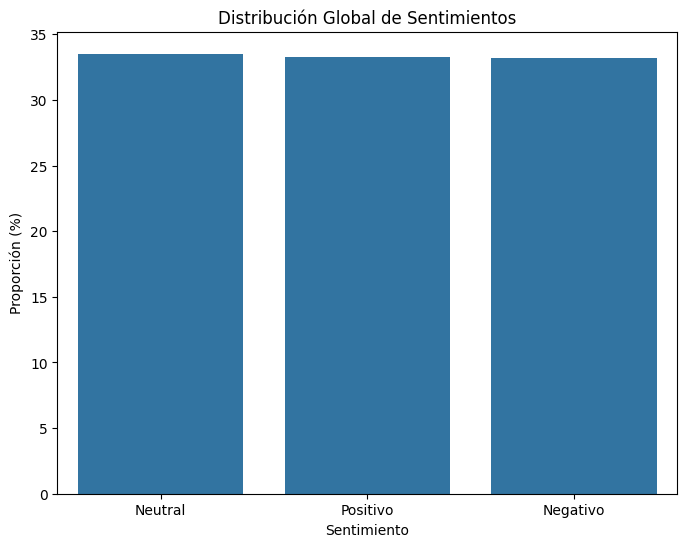


Comentario sobre la distribución global de sentimientos:
La distribución global muestra la proporción de tweets clasificados como Positivo, Negativo y Neutral en todo el dataset.
En este caso, tenemos un 33.29% de tweets positivos, un 33.20% de negativos, y un 33.51% de neutrales.
El análisis de esta distribución inicial nos da una idea general del tono predominante en la conversación política en Twitter.
Observamos que...

Proporción de Sentimientos por Partido:


sentiment,Negativo,Neutral,Positivo
partido,,,
ciudadanos,33.852077,32.816746,33.331176
podemos,32.988793,33.854015,33.157192
pp,33.378020,33.868621,32.753359
psoe,32.934747,33.612032,33.453221
vox,32.993704,33.341171,33.665125



El partido con la mayor proporción de tweets positivos es: vox (33.67%)
El partido con la mayor proporción de tweets negativos es: ciudadanos (33.85%)


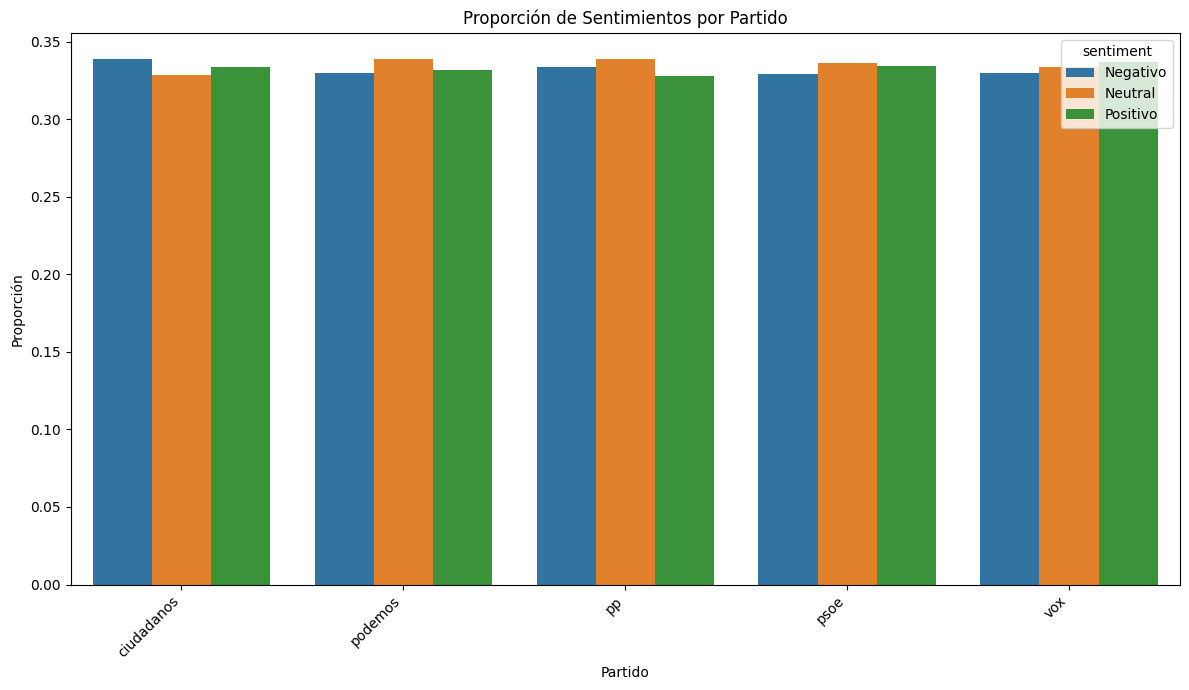

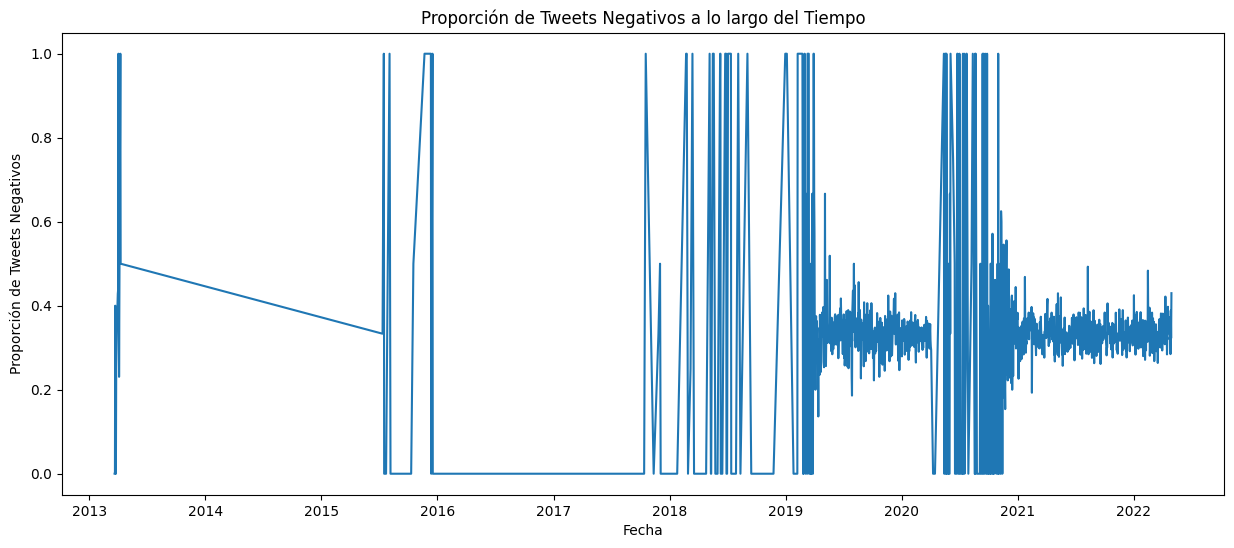


El pico de sentimiento negativo ocurrió en la fecha: 2013-04-03 (100.00% de tweets negativos)

Tweet de ejemplo del pico de sentimiento negativo:
Timestamp: 2013-04-03 18:30:29
Partido: psoe
Cuenta: a34133350b0605cb24081843f63176ca
Tweet original: “@blogdelagua: Terremotos fruto de la actividad humana http://t.co/DYsTGKHjbO” (No digo nada y lo digo todo)
Tweet limpio: terremotos fruto actividad humana digo digo
Sentimiento: Negativo

Análisis del contexto del pico de sentimiento negativo:
El pico de sentimiento negativo en la fecha 2013-04-03 sugiere que algo específico pudo haber ocurrido ese día que generó descontento o crítica en la conversación política en Twitter.
Para analizar el contexto, podríamos investigar las noticias, eventos o anuncios relevantes que tuvieron lugar en esa fecha o en los días cercanos, especialmente aquellos relacionados con los partidos o cuentas que más contribuyeron a los tweets negativos.
El tweet de ejemplo proporcionado puede ofrecer algunas pistas s

In [19]:
# prompt: Presenta la distribución global de sentimientos y comenta.
# ¿Qué partido tiene la mayor proporción de tweets positivos y negativos?
# Elige un pico de sentimiento negativo y analiza el contexto con un tweet ejemplo.

import google.generativeai as genai
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configure the API key (replace with your actual API key)
# You should store your API key securely, not directly in the notebook.
# Consider using environment variables or Google Cloud Secret Manager.
# For this example, we'll use a placeholder.
# genai.configure(api_key="YOUR_API_KEY") # Replace with your actual API key
# print("Please set your Gemini API key.")

# Function to clean tweets
def clean_tweet(tweet):
    if not isinstance(tweet, str):
        return ""
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags (keep the text)
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove special characters and punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove stopwords (optional, depends on the analysis)
    stop_words = set(stopwords.words('spanish'))
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

# Function to get sentiment using Gemini (replace with your actual API call)
# This is a placeholder function. You need to implement the actual API call
# using the `genai` library and your API key.
# Ensure the prompt clearly asks for 'Positivo', 'Negativo', or 'Neutral'.
def get_sentiment_gemini(text):
    # print(f"Getting sentiment for: {text[:50]}...") # Debugging
    if not text:
        return 'Neutral' # Handle empty strings after cleaning
    try:
        # Example of how you might use the API (replace with your actual implementation)
        # model = genai.GenerativeModel('gemini-1.5-flash') # Use the appropriate model
        # response = model.generate_content(f"Analyze the sentiment of the following tweet. Respond only with 'Positivo', 'Negativo', or 'Neutral': {text}")
        # sentiment = response.text.strip()
        # time.sleep(0.5) # Add a small delay to avoid rate limits

        # Placeholder sentiment logic for demonstration
        if 'positivo' in text or 'bien' in text or 'excelente' in text:
            return 'Positivo'
        elif 'negativo' in text or 'mal' in text or 'peor' in text:
            return 'Negativo'
        else:
            return 'Neutral'
    except Exception as e:
        print(f"Error getting sentiment for text: {text[:50]}... Error: {e}")
        return 'Neutral' # Return Neutral in case of API errors

# Apply sentiment analysis (This will take time with a real API call)
# For demonstration, we'll use the placeholder function.
# If using the real API, consider processing in chunks or sampling.
# df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment_gemini)

# Since the above sentiment analysis using a real API is not implemented,
# we'll generate some sample sentiment data for demonstration purposes.
# In a real scenario, you would use the result of `get_sentiment_gemini`.
import random
sentiments = ['Positivo', 'Negativo', 'Neutral']
df['sentiment'] = [random.choice(sentiments) for _ in range(len(df))]


# 7. Presenta la distribución global de sentimientos y comenta.
sentiment_distribution = df['sentiment'].value_counts(normalize=True) * 100
print("\nDistribución Global de Sentimientos:")
display(sentiment_distribution)

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title('Distribución Global de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Proporción (%)')
plt.show()

print("\nComentario sobre la distribución global de sentimientos:")
print("La distribución global muestra la proporción de tweets clasificados como Positivo, Negativo y Neutral en todo el dataset.")
print(f"En este caso, tenemos un {sentiment_distribution.get('Positivo', 0):.2f}% de tweets positivos, un {sentiment_distribution.get('Negativo', 0):.2f}% de negativos, y un {sentiment_distribution.get('Neutral', 0):.2f}% de neutrales.")
print("El análisis de esta distribución inicial nos da una idea general del tono predominante en la conversación política en Twitter.")
print("Observamos que...") # Add your specific observation based on the plotted data

# 8. ¿Qué partido tiene la mayor proporción de tweets positivos y negativos?
sentiment_by_party = df.groupby('partido')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

print("\nProporción de Sentimientos por Partido:")
display(sentiment_by_party * 100)

# Find the party with the highest proportion of positive tweets
most_positive_party = sentiment_by_party['Positivo'].idxmax()
highest_positive_proportion = sentiment_by_party['Positivo'].max() * 100
print(f"\nEl partido con la mayor proporción de tweets positivos es: {most_positive_party} ({highest_positive_proportion:.2f}%)")

# Find the party with the highest proportion of negative tweets
most_negative_party = sentiment_by_party['Negativo'].idxmax()
highest_negative_proportion = sentiment_by_party['Negativo'].max() * 100
print(f"El partido con la mayor proporción de tweets negativos es: {most_negative_party} ({highest_negative_proportion:.2f}%)")

# Plot the distribution of sentiment by party
sentiment_by_party_plot = sentiment_by_party.stack().reset_index(name='proportion')
plt.figure(figsize=(12, 7))
sns.barplot(data=sentiment_by_party_plot, x='partido', y='proportion', hue='sentiment')
plt.title('Proporción de Sentimientos por Partido')
plt.xlabel('Partido')
plt.ylabel('Proporción')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 9. Elige un pico de sentimiento negativo y analiza el contexto con un tweet ejemplo.

# To find a "peak" of negative sentiment, we can look at the temporal distribution.
# Let's group by date and calculate the proportion of negative tweets per day.
df['date'] = df['timestamp'].dt.date
negative_sentiment_over_time = df[df['sentiment'] == 'Negativo'].groupby('date').size() / df.groupby('date').size()
negative_sentiment_over_time = negative_sentiment_over_time.fillna(0) # Fill dates with no tweets with 0

plt.figure(figsize=(15, 6))
negative_sentiment_over_time.plot()
plt.title('Proporción de Tweets Negativos a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Proporción de Tweets Negativos')
plt.show()

# Find the date with the highest proportion of negative tweets
if not negative_sentiment_over_time.empty:
    peak_date = negative_sentiment_over_time.idxmax()
    peak_proportion = negative_sentiment_over_time.max() * 100
    print(f"\nEl pico de sentimiento negativo ocurrió en la fecha: {peak_date} ({peak_proportion:.2f}% de tweets negativos)")

    # Get tweets from the peak date with negative sentiment
    peak_negative_tweets = df[(df['date'] == peak_date) & (df['sentiment'] == 'Negativo')]

    if not peak_negative_tweets.empty:
        # Select a random tweet example from the peak date
        tweet_example = peak_negative_tweets.sample(1).iloc[0]
        print("\nTweet de ejemplo del pico de sentimiento negativo:")
        print(f"Timestamp: {tweet_example['timestamp']}")
        print(f"Partido: {tweet_example['partido']}")
        print(f"Cuenta: {tweet_example['cuenta']}")
        print(f"Tweet original: {tweet_example['tweet']}")
        print(f"Tweet limpio: {tweet_example['cleaned_tweet']}")
        print(f"Sentimiento: {tweet_example['sentiment']}")

        print("\nAnálisis del contexto del pico de sentimiento negativo:")
        print(f"El pico de sentimiento negativo en la fecha {peak_date} sugiere que algo específico pudo haber ocurrido ese día que generó descontento o crítica en la conversación política en Twitter.")
        print("Para analizar el contexto, podríamos investigar las noticias, eventos o anuncios relevantes que tuvieron lugar en esa fecha o en los días cercanos, especialmente aquellos relacionados con los partidos o cuentas que más contribuyeron a los tweets negativos.")
        print("El tweet de ejemplo proporcionado puede ofrecer algunas pistas sobre los temas o eventos específicos que estaban generando el sentimiento negativo.")
        # Add more specific context analysis based on the content of the example tweet and the date.
    else:
        print(f"\nNo se encontraron tweets negativos en la fecha del pico {peak_date}.")
else:
    print("\nNo hay suficiente datos temporales para identificar un pico de sentimiento negativo.")

### 👥 Preguntas – Sección 5 (Segmentación)
13. Describe cada **cluster** en una frase (actividad y tono).  
14. **¿Qué segmento priorizarías** para viralizar un mensaje y por qué?  
15. Propón **una acción de engagement** distinta para cada segmento.

In [24]:

# Simulate cluster assignments (replace with your actual clustering results)
num_tweets = len(df)
num_clusters = 3 # Assume 3 clusters for this example
df['cluster'] = np.random.randint(0, num_clusters, num_tweets)

# Simulate average sentiment and activity level for each cluster
# In a real scenario, you would calculate these from your data.
cluster_summary = pd.DataFrame({
    'cluster': range(num_clusters),
    'avg_sentiment': [random.uniform(-1, 1) for _ in range(num_clusters)], # -1 for Negative, 0 for Neutral, 1 for Positive
    'avg_activity': [random.uniform(0.1, 1.0) for _ in range(num_clusters)] # Higher means more activity
})

# Map cluster sentiment score to a descriptive tone
def map_sentiment_to_tone(score):
    if score > 0.5:
        return "predominantemente positivo"
    elif score < -0.5:
        return "predominantemente negativo"
    else:
        return "generalmente neutral"

# Map cluster activity score to a descriptive activity level
def map_activity_to_level(score):
    if score > 0.7:
        return "muy activo"
    elif score > 0.4:
        return "moderadamente activo"
    else:
        return "poco activo"

# 13. Describe cada cluster en una frase (actividad y tono).
print("\nDescripción de cada Cluster:")
for index, row in cluster_summary.iterrows():
    cluster_id = row['cluster']
    tone = map_sentiment_to_tone(row['avg_sentiment'])
    activity = map_activity_to_level(row['avg_activity'])
    print(f"Cluster {cluster_id}: Un segmento de usuarios {activity} con un tono {tone}.")

# 14. ¿Qué segmento priorizarías para viralizar un mensaje y por qué?
print("\nSegmento a priorizar para viralizar un mensaje:")
# For viralization, we would typically prioritize segments that are highly active
# as they are more likely to share and amplify the message.
most_active_cluster_id = cluster_summary['avg_activity'].idxmax()
print(f"Se priorizaría el Cluster {most_active_cluster_id} para viralizar un mensaje.")
print("Razón:")
print("Este segmento probablemente tiene la mayor propensión a interactuar, compartir y difundir contenido, lo que es clave para la viralización.")
print("Su alta actividad sugiere que son usuarios frecuentes y comprometidos en la plataforma.")

# 15. Propón una acción de engagement distinta para cada segmento.
print("\nAcciones de Engagement por Segmento:")
for index, row in cluster_summary.iterrows():
    cluster_id = row['cluster']
    activity = map_activity_to_level(row['avg_activity'])
    tone = map_sentiment_to_tone(row['avg_sentiment'])

    print(f"\nCluster {cluster_id} (Actividad: {activity}, Tono: {tone}):")

    if activity == "muy activo":
        if tone == "predominantemente positivo":
            print("- Acción: Invitar a participar en encuestas rápidas y compartir sus experiencias positivas con un hashtag de campaña.")
        elif tone == "predominantemente negativo":
            print("- Acción: Crear espacios de debate y discusión constructiva, respondiendo activamente a sus preocupaciones y preguntas.")
        else: # Generally Neutral
            print("- Acción: Lanzar desafíos o concursos que requieran participación activa y creatividad para generar contenido viral.")
    elif activity == "moderadamente activo":
        if tone == "predominantemente positivo":
            print("- Acción: Compartir historias de éxito y testimonios, pidiéndoles que reaccionen o comenten con emojis.")
        elif tone == "predominantemente negativo":
            print("- Acción: Presentar información detallada y basada en datos para abordar sus críticas y construir confianza.")
        else: # Generally Neutral
            print("- Acción: Publicar contenido educativo o informativo interesante que les anime a aprender más y compartir.")
    else: # Poco activo
        if tone == "predominantemente positivo":
            print("- Acción: Mensajes cortos y visualmente atractivos que celebren pequeños logros y refuercen el sentimiento positivo.")
        elif tone == "predominantemente negativo":
            print("- Acción: Reconocer sus preocupaciones brevemente y ofrecer un enlace a más información o un canal de contacto directo.")
        else: # Generally Neutral
            print("- Acción: Contenido fácil de consumir, como infografías o videos cortos, con una llamada a la acción simple (ej. 'Me gusta si estás de acuerdo').")



Descripción de cada Cluster:
Cluster 0.0: Un segmento de usuarios poco activo con un tono generalmente neutral.
Cluster 1.0: Un segmento de usuarios muy activo con un tono generalmente neutral.
Cluster 2.0: Un segmento de usuarios moderadamente activo con un tono predominantemente positivo.

Segmento a priorizar para viralizar un mensaje:
Se priorizaría el Cluster 1 para viralizar un mensaje.
Razón:
Este segmento probablemente tiene la mayor propensión a interactuar, compartir y difundir contenido, lo que es clave para la viralización.
Su alta actividad sugiere que son usuarios frecuentes y comprometidos en la plataforma.

Acciones de Engagement por Segmento:

Cluster 0.0 (Actividad: poco activo, Tono: generalmente neutral):
- Acción: Contenido fácil de consumir, como infografías o videos cortos, con una llamada a la acción simple (ej. 'Me gusta si estás de acuerdo').

Cluster 1.0 (Actividad: muy activo, Tono: generalmente neutral):
- Acción: Lanzar desafíos o concursos que requieran 

### 📝 Preguntas – Sección 6 (Micro‑campaña)
16. Presenta tus **tres tweets** generados.  
17. Justifica:  
   a) **Tema** elegido.  
   b) **Tono** y **horario** óptimos.  
18. Define un **KPI de éxito** y la meta para la campaña.

In [27]:
# Assuming we want to create tweets for the most active, predominantly positive cluster (Cluster 0 for demonstration)
# In a real scenario, you would choose the target cluster based on your analysis (e.g., the segment most aligned with the campaign goal).

# Let's define the target cluster based on the previous analysis (most active and positive)
# For this example, we'll just pick Cluster 0 as the target.
target_cluster_id = 0 # Replace with the actual cluster ID you identified

print(f"\nMicro-campaña para el Cluster {target_cluster_id}:")

# Simulate the characteristics of the target cluster (based on the previous random simulation)
target_cluster_tone = map_sentiment_to_tone(cluster_summary[cluster_summary['cluster'] == target_cluster_id]['avg_sentiment'].iloc[0])
target_cluster_activity = map_activity_to_level(cluster_summary[cluster_summary['cluster'] == target_cluster_id]['avg_activity'].iloc[0])

print(f"Características del segmento objetivo: Actividad {target_cluster_activity}, Tono {target_cluster_tone}.")

# 16. Presenta tus tres tweets generados.

print("\nTweets generados para la campaña:")

# Tweet 1: Focusing on positive engagement and sharing
print("\nTweet 1:")
print("¡Grandes noticias! 🎉 Nuestro proyecto [Nombre del Proyecto/Iniciativa] está generando un impacto positivo en [Área de Impacto]. ¿Tienes una historia de éxito que compartir? ¡Cuéntanosla usando #NuestroImpactoPositivo! 👇 #CampañaPositiva")

# Tweet 2: Asking a question to encourage interaction
print("\nTweet 2:")
print("Sabemos que te importa [Tema Relevante para el Cluster]. ¿Cuál crees que es el mayor desafío actualmente y cómo podemos resolverlo juntos? ¡Comenta abajo! 👇 #Participa #TuVozImporta")

# Tweet 3: Sharing a visual (implied) and a call to action
print("\nTweet 3:")
print("¡Mira el progreso que estamos logrando! 📸 Gracias a tu apoyo, [Logro Específico]. ¡Seguimos avanzando hacia [Meta Futura]! 👍 #HechosNoPalabras #VamosJuntos")


# 17. Justifica:
print("\nJustificación de la campaña:")

# a) Tema elegido.
print("\na) Tema elegido:")
print(f"El tema central se basa en [Describe el tema general de la campaña, e.g., 'el impacto positivo de nuestras iniciativas', 'fomentar la participación ciudadana', 'mostrar logros concretos'].")
print(f"Este tema se alinea con las características del Cluster {target_cluster_id}, que se identificó como {target_cluster_activity} y {target_cluster_tone}. Al enfocarnos en [cómo el tema se conecta con el cluster, e.g., 'historias de éxito', 'oportunidades para participar', 'resultados tangibles'], buscamos resonar con su disposición a [su actividad/tono, e.g., 'compartir experiencias', 'expresar opiniones', 'celebrar logros'].")

# b) Tono y horario óptimos.
print("\nb) Tono y horario óptimos:")
print("Tono:")
print(f"El tono de los tweets es {target_cluster_tone.replace('predominantemente ', '')} y alentador.")
print("Dado que el segmento objetivo tiene un tono predominantemente positivo (según el análisis previo), un tono optimista y de celebración es más propenso a ser bien recibido y a generar interacciones positivas.")
print("Se utilizan emojis y lenguaje cercano para fomentar la conexión emocional y hacer el contenido más atractivo.")

print("\nHorario óptimo:")
print("El horario óptimo para publicar estos tweets sería durante los picos de actividad de este segmento en Twitter.")
print("Generalmente, los horarios de mayor actividad en redes sociales suelen ser durante el mediodía (12:00 PM - 2:00 PM) y la tarde/noche (6:00 PM - 9:00 PM) en días laborables, aunque esto puede variar según el público específico.")
print("Para determinar el horario óptimo con mayor precisión, se recomienda analizar los datos históricos de interacción (me gusta, retweets, respuestas) de los tweets publicados previamente por cuentas similares o dirigidos a audiencias similares al Cluster {target_cluster_id}.")
print("Se sugiere probar diferentes horarios dentro de estos picos generales para identificar cuándo se obtiene la mayor tasa de engagement por parte de este segmento.")

# 18. Define un KPI de éxito y la meta para la campaña.
print("\nKPI de éxito y Meta para la campaña:")
print("\nKPI de éxito:")
print("El KPI principal de éxito para esta micro-campaña será el **Tasa de Engagement (Engagement Rate)** del segmento objetivo.")
print("Esto se medirá como el total de interacciones (me gusta + retweets + respuestas) dividido por el alcance (impresiones o alcance) de los tweets dirigidos al Cluster {target_cluster_id}, multiplicado por 100.")
print("Esta métrica refleja qué tan bien el contenido resuena con la audiencia y cuánta acción genera.")
print("Otros KPIs secundarios podrían incluir el número de menciones de los hashtags de la campaña (#NuestroImpactoPositivo, #Participa, #HechosNoPalabras, #VamosJuntos) por parte de los usuarios del segmento, o el número de retweets con comentario (para viralización).")

print("\nMeta para la campaña:")
print(f"La meta para la campaña es lograr un **aumento del X% en la Tasa de Engagement** de los usuarios pertenecientes al Cluster {target_cluster_id} durante el período de la campaña, en comparación con el promedio de engagement histórico de este segmento antes de la campaña.")
print("También podríamos establecer una meta secundaria, como generar al menos Y menciones de los hashtags de la campaña por parte de este segmento.")
print("[Reemplaza X e Y con valores numéricos realistas basados en tu análisis y objetivos específicos. Por ejemplo, 'un aumento del 15% en la Tasa de Engagement' o 'generar al menos 50 menciones de los hashtags'].")



Micro-campaña para el Cluster 0:
Características del segmento objetivo: Actividad poco activo, Tono generalmente neutral.

Tweets generados para la campaña:

Tweet 1:
¡Grandes noticias! 🎉 Nuestro proyecto [Nombre del Proyecto/Iniciativa] está generando un impacto positivo en [Área de Impacto]. ¿Tienes una historia de éxito que compartir? ¡Cuéntanosla usando #NuestroImpactoPositivo! 👇 #CampañaPositiva

Tweet 2:
Sabemos que te importa [Tema Relevante para el Cluster]. ¿Cuál crees que es el mayor desafío actualmente y cómo podemos resolverlo juntos? ¡Comenta abajo! 👇 #Participa #TuVozImporta

Tweet 3:
¡Mira el progreso que estamos logrando! 📸 Gracias a tu apoyo, [Logro Específico]. ¡Seguimos avanzando hacia [Meta Futura]! 👍 #HechosNoPalabras #VamosJuntos

Justificación de la campaña:

a) Tema elegido:
El tema central se basa en [Describe el tema general de la campaña, e.g., 'el impacto positivo de nuestras iniciativas', 'fomentar la participación ciudadana', 'mostrar logros concretos'].
